# 3.2 线性回归的从零开始实现

在了解了线性回归的背景知识之后，现在我们可以动手实现它了。尽管强大的深度学习框架可以减少大量重复性工作，但若过于依赖它提供的便利，会导致我们很难深入理解深度学习是如何工作的。因此，本节将介绍如何只利用Tensor和GradientTape来实现一个线性回归的训练

导包

In [135]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import random
%matplotlib inline

print(tf.__version__)
    # 2.2.0

2.2.0


3.2.1 生成数据集
---
我们构造一个简单的人工训练数据集，它可以使我们能够直观比较学到的参数和真实的模型参数的区别。设训练数据集样本数为1000，输入个数（特征数）为2。给定随机生成的批量样本特征 $X ∈ R^{1000x2}$
 ，我们使用线性回归模型真实权重$ w=[2,−3.4]^⊤$
  和偏差 b=4.2，以及一个随机噪声项 ϵ 来生成标签 $$ y = Xw+b+ϵ $$
其中噪声项ϵ服从均值为0，标准差为0.01的正态分布。噪声代表了数据集中无意义的干扰。下面，使用这种形式生成数据集。

（吴恩达老师的讲法）也可以$X ∈ R^{2xm}$ $w=[2,−3.4]$，那么生成标签为： $$ y = wX+b+ϵ $$


In [136]:
num_inputs = 2
num_examples = 1000
true_w = [2,-3.4]
true_b = 4.2
features = tf.random.normal(
    shape=(num_examples,num_inputs),
    mean=0.0,
    stddev=1)

# wx+b
labels = true_w[0]*features[:,0]+true_w[1]*features[:,1]+true_b
    # 等价向量化为labels = x*transpose(w)+b
        # 那么尺寸为(1000,2)*(2,1)+(1000,1)=>(1000,1)

# 噪声
labels += tf.random.normal(
    shape=labels.shape,
    mean=0.0,
    stddev=0.01)

注意，features的每一行是一个长度为2的向量，而labels的每一行是一个长度为1的向量（标量）

In [137]:
print(features[0],labels[0])

tf.Tensor([1.2763801  0.07339173], shape=(2,), dtype=float32) tf.Tensor(6.5081067, shape=(), dtype=float32)


通过生成第二个特征features[:, 1]和标签 labels 的散点图，可以更直观地观察两者间的线性关系。

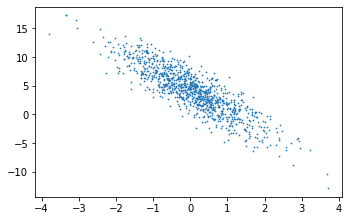

In [138]:
def set_figsize(figsize=(5.5,3.5)):
    plt.rcParams['figure.figsize'] = figsize
        #rc简写run configuration

set_figsize()
plt.scatter(x=features[:,1],y=labels,s=0.5)
    # 参数s：颗粒大小

3.2.2 读取数据
---

在训练模型的时候，我们需要遍历数据集并不断读取小批量数据样本。这里我们定义一个函数：它每次返回batch_size（批量大小）个随机样本的特征和标签——"子features"和"子labels"

In [141]:
def data_iter(batch_size,features,labels):
    num_examples = len(features) # 获得总样本数量
    indices = list(range(0,num_examples))
    random.shuffle(indices) # 洗牌
    for i in range(0,num_examples,batch_size):
        j = indices[i:min(i+batch_size,num_examples)]
        yield tf.gather(params=features,indices=j,axis=0),\
              tf.gather(params=labels,indices=j,axis=0)
        
            # tf.gather()
                # docstrings: Gather slices from params axis `axis` according to indices.
        

In [142]:
# 测试data_iter() 
batch_size = 10
for X,y in data_iter(batch_size,features,labels):
    print(X,y)
    break

tf.Tensor(
[[-0.9805553   0.52415913]
 [-1.1895803   0.21512488]
 [ 0.5898868   0.5134069 ]
 [ 0.02777003  1.2330498 ]
 [ 0.48656088  0.37721115]
 [-0.879967    1.4509336 ]
 [ 0.60118216 -0.6790095 ]
 [ 0.24877065 -1.1020476 ]
 [-0.0259544  -0.74877214]
 [ 0.09126366  0.9967373 ]], shape=(10, 2), dtype=float32) tf.Tensor(
[ 0.44683564  1.0867982   3.633434    0.06248729  3.8988402  -2.4988923
  7.722994    8.438548    6.702274    0.9659691 ], shape=(10,), dtype=float32)


3.2.3 初始化模型参数
---

我们将权重初始化成均值为0、标准差为0.01的正态随机数。偏差则初始化成0标量。

In [143]:

w = tf.Variable(tf.random.normal(shape=(num_inputs,1),
                                 mean=0,
                                 stddev=0.01))
b = tf.Variable(tf.zeros(shape=(1,)))

3.2.4 定义模型
---
$X_{(m,2)}w_{(2,1)}+b =>\hat{y}_{(m,1)}$


linear regression简写linreg

In [144]:
def linreg(X,w,b):
    return tf.matmul(a=X,b=w)+b

3.2.5 定义损失函数
---
平方损失来定义线性回归的损失函数。在实现中，我们需要把真实值y变形成预测值y_hat的形状。

 tf.reshape(tensor,shape)是返回值改变尺寸，tensor参数本身不会改变尺寸。

In [151]:
def squared_loss(y_hat,y):
    return (y_hat - tf.reshape(y,shape=y_hat.shape))**2 /2
       

3.2.6 定义优化算法(更新参数来优化损失函数)
---

小批量随机梯度下降算法。比如：$ w:= w - 学习率 \frac{θJ}{θw}$

参数中的grads是自动求梯度模块计算得来的梯度，这是一个批量样本的梯度和。我们将它除以批量大小来得到平均值。

In [152]:
def sgd(params,lr,batch_size,grads):
    """Mini-batch stochastic gradient descent."""
    for i,param in enumerate(params):
        param.assign_sub(lr*grads[i] / batch_size)
            # Subtracts a value from this variable.

3.2.7 训练模型
---

提前设置好超参数，然后进行训练

In [153]:
lr = 0.03
num_epochs = 3
net = linreg # 模型
loss = squared_loss #损失函数
batch_size =10

for epoch in range(num_epochs):
    # 一个个batch去更新参数
    for X,y in data_iter(batch_size,features,labels):
        with tf.GradientTape() as t:
            t.watch([w,b]) # 跟踪w,b
            l = loss(net(X,w,b),y) # 先前传播
        grads = t.gradient(l,[w,b]) # 批量样本的梯度和
        sgd([w,b],lr,batch_size,grads) # 更新参数
    # 评估训练集上损失
    train_l = loss(net(features,w,b),labels)
    print('epoch%d,loss %f'%(epoch+1,tf.reduce_mean(train_l)))
    

epoch1,loss 0.034467
epoch2,loss 0.000128
epoch3,loss 0.000050


---
验证一下，学习到的参数是否接近真实参数？应该非常接近。

In [159]:
print(true_w, w)

[2, -3.4] <tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[ 2.0012298],
       [-3.4013243]], dtype=float32)>


In [160]:
print(true_b, b)

4.2 <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([4.199328], dtype=float32)>
